In [16]:
from google.colab import drive
drive.mount('/content/drive')





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt



In [40]:
def extract_patches_from_image(image, patch_size):
    """Extract non-overlapping patches from an image."""
    patches = []
    for y in range(0, image.shape[0], patch_size):
        for x in range(0, image.shape[1], patch_size):
            patch = image[y:y+patch_size, x:x+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size and patch.shape[2] == 3:
                patches.append(patch)
    return np.array(patches)

def calculate_discrete_image_gradient(patch):
    """Calculate the discrete image gradient sum for a patch."""
    M, N, C = patch.shape
    div = np.zeros((M, N))

    # Interior pixels gradient
    for i in range(M - 1):
        for j in range(N - 1):
            for c in range(C):
                div[i, j] += abs(patch[i, j, c] - patch[i, j + 1, c])
                div[i, j] += abs(patch[i, j, c] - patch[i + 1, j, c])

    # Bottom row and rightmost column gradients
    for j in range(N - 1):  # Bottom row
        for c in range(C):
            div[M - 1, j] += abs(patch[M - 1, j, c] - patch[M - 1, j + 1, c])

    for i in range(M - 1):  # Rightmost column
        for c in range(C):
            div[i, N - 1] += abs(patch[i, N - 1, c] - patch[i + 1, N - 1, c])

    return div.sum()  # Sum of gradient values

def reconstruct_image_from_ordered_patches(patches, order, patch_size, num_channels):
    """Reconstruct the image from ordered patches."""
    num_patches_per_row = int(np.sqrt(len(order)))
    img_height = img_width = patch_size * num_patches_per_row
    reconstructed_image = np.zeros((img_height, img_width, num_channels), dtype=patches[0].dtype)

    for idx, patch_idx in enumerate(order):
        row = idx // num_patches_per_row
        col = idx % num_patches_per_row
        reconstructed_image[row*patch_size:(row+1)*patch_size, col*patch_size:(col+1)*patch_size, :] = patches[patch_idx]

    return reconstructed_image

def smash_and_reconstruct(image, patch_size=32):
    """Perform the Smash and Reconstruct process using the discrete image gradient."""
    patches = extract_patches_from_image(image, patch_size)
    gradients = np.array([calculate_discrete_image_gradient(patch) for patch in patches])
    order_rich_to_poor = np.argsort(-gradients)  # Order by descending gradient sum
    order_poor_to_rich = np.argsort(gradients)   # Order by ascending gradient sum

    num_channels = image.shape[2] if len(image.shape) == 3 else 1
    rich_texture_image = reconstruct_image_from_ordered_patches(patches, order_rich_to_poor, patch_size, num_channels)
    poor_texture_image = reconstruct_image_from_ordered_patches(patches, order_poor_to_rich, patch_size, num_channels)

    return rich_texture_image, poor_texture_image

<ipython-input-40-df10d756f4c2>:21: RuntimeWarning: overflow encountered in scalar subtract
  div[i, j] += abs(patch[i, j, c] - patch[i + 1, j, c])
<ipython-input-40-df10d756f4c2>:20: RuntimeWarning: overflow encountered in scalar subtract
  div[i, j] += abs(patch[i, j, c] - patch[i, j + 1, c])
<ipython-input-40-df10d756f4c2>:26: RuntimeWarning: overflow encountered in scalar subtract
  div[M - 1, j] += abs(patch[M - 1, j, c] - patch[M - 1, j + 1, c])
<ipython-input-40-df10d756f4c2>:30: RuntimeWarning: overflow encountered in scalar subtract
  div[i, N - 1] += abs(patch[i, N - 1, c] - patch[i + 1, N - 1, c])


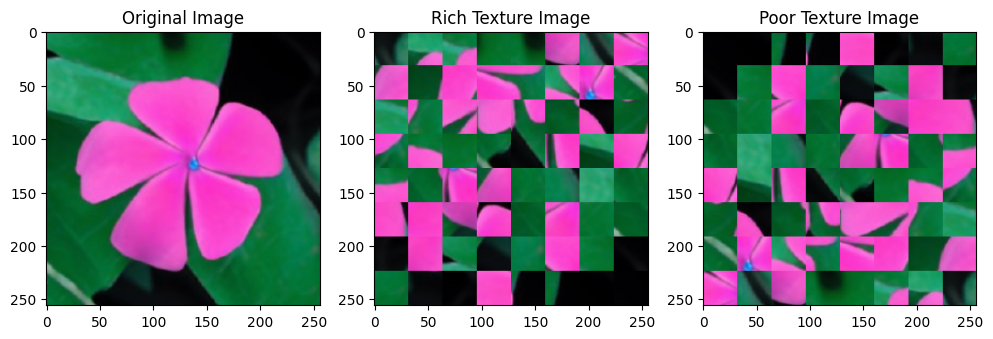

In [41]:
img_path = '/img1.jpeg'
img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Change to cv2.IMREAD_COLOR

# Make sure to convert from BGR (OpenCV default) to RGB if you're going to display with matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rich_texture_img, poor_texture_img = smash_and_reconstruct(img)

# Display the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(rich_texture_img, cmap='gray')
plt.title('Rich Texture Image')
plt.subplot(1, 3, 3)
plt.imshow(poor_texture_img, cmap='gray')
plt.title('Poor Texture Image')
plt.show()

In [42]:
# import PIL.Image
# import cv2
# import numpy as np
# import random
# import concurrent.futures

# def img_to_patches1(input_path:str) -> tuple:
#     """
#     Returns 32x32 patches of a resized 256x256 images,
#     it returns 64x64 patches on grayscale and 64x64 patches
#     on the RGB color scale
#     --------------------------------------------------------
#     ## parameters:
#     - input_path: Accepts input path of the image
#     """
#     img = PIL.Image.open(fp=input_path)
#     if(input_path[-3:]!='jpg' or input_path[-4:]!='jpeg'):
#         img = img.convert('RGB')
#     if(img.size!=(256,256)):
#         img = img.resize(size=(256,256))
#     patch_size = 32
#     grayscale_imgs = []
#     imgs = []
#     for i in range(0,img.height,patch_size):
#         for j in range(0, img.width, patch_size):
#             box = (j,i,j+patch_size,i+patch_size)
#             img_color = np.asarray(img.crop(box))
#             grayscale_image = cv2.cvtColor(src=img_color, code=cv2.COLOR_RGB2GRAY)
#             grayscale_imgs.append(grayscale_image.astype(dtype=np.int32))
#             imgs.append(img_color)
#     return grayscale_imgs,imgs



# def get_l11(v,x,y):
#     l1=0
#     # 1 to m, 1 to m-1
#     for i in range(0,y-1):
#         for j  in range(0,x):
#             l1+=abs(v[j][i]-v[j][i+1])
#     return l1

# def get_l21(v,x,y):
#     l2=0
#     # 1 to m-1, 1 to m
#     for i in range(0,y):
#         for j  in range(0,x-1):
#             l2+=abs(v[j][i]-v[j+1][i])
#     return l2

# def get_l3l41(v,x,y):
#     l3=l4=0
#     # 1 to m-1, 1 to m-1
#     for i in range(0,y-1):
#         for j  in range(0,x-1):
#             l3+=abs(v[j][i]-v[j+1][i+1])
#             l4+=abs(v[j+1][i]-v[j][i+1])

#     return l3+l4

# def get_pixel_var_degree_for_patch1(patch:np.array)->int:
#     """
#     gives pixel variation for a given patch
#     ---------------------------------------
#     ## parameters:
#     - patch: accepts a numpy array format of the patch of an image
#     """
#     x,y = patch.shape
#     l1=l2=l3l4=0

#     with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
#         future_l1 = executor.submit(get_l11,patch,x,y)
#         future_l2 = executor.submit(get_l21,patch,x,y)
#         future_l3l4 = executor.submit(get_l3l41,patch,x,y)

#         l1 = future_l1.result()
#         l2 = future_l2.result()
#         l3l4 = future_l3l4.result()

#     return  l1+l2+l3l4


# def extract_rich_and_poor_textures1(variance_values:list, patches:list):
#     """
#     returns a list of rich texture and poor texture patches respectively
#     --------------------------------------------------------------------
#     ## parameters:
#     - variance_values: list of values that are pixel variances of each patch
#     - color_patches: coloured patches of the target image
#     """
#     threshold = np.mean(variance_values)
#     rich_texture_patches = []
#     poor_texture_patches = []
#     for i,j in enumerate(variance_values):
#         if j >= threshold:
#             rich_texture_patches.append(patches[i])
#         else:
#             poor_texture_patches.append(patches[i])

#     return rich_texture_patches, poor_texture_patches



# def get_complete_image1(patches:list, coloured=True):
#     """
#     Develops complete 265x256 image from rich and poor texture patches
#     ------------------------------------------------------------------
#     ## parameters:
#     - patches: Takes a list of rich or poor texture patches
#     """
#     random.shuffle(patches)
#     p_len = len(patches)
#     while len(patches)<64:
#         patches.append(patches[random.randint(0, p_len-1)])

#     if(coloured==True):
#         grid = np.asarray(patches).reshape((8,8,32,32,3))
#     else:
#         grid = np.asarray(patches).reshape((8,8,32,32))


#     # joins columns to only leave rows
#     rows = [np.concatenate(grid[i,:], axis=1) for i in range(8)]

#     # joins the rows to create the final image
#     img = np.concatenate(rows,axis=0)

#     return img



# def smash_n_reconstruct1(input_path:str, coloured=True):
#     """
#     Performs the SmashnReconstruct part of preprocesing
#     reference: [link](https://arxiv.org/abs/2311.12397)

#     return rich_texture,poor_texture

#     ----------------------------------------------------
#     ## parameters:
#     - input_path: Accepts input path of the image
#     """
#     gray_scale_patches, color_patches = img_to_patches1(input_path=input_path)
#     pixel_var_degree = []
#     for patch in gray_scale_patches:
#         pixel_var_degree.append(get_pixel_var_degree_for_patch1(patch))

#     # r_patch = list of rich texture patches, p_patch = list of poor texture patches
#     if(coloured):
#         r_patch,p_patch = extract_rich_and_poor_textures1(variance_values=pixel_var_degree,patches=color_patches)
#     else:
#         r_patch,p_patch = extract_rich_and_poor_textures1(variance_values=pixel_var_degree,patches=gray_scale_patches)
#     rich_texture,poor_texture = None,None

#     with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
#         rich_texture_future = executor.submit(get_complete_image1,r_patch,coloured)
#         poor_texture_future = executor.submit(get_complete_image1,p_patch,coloured)

#         rich_texture = rich_texture_future.result()
#         poor_texture = poor_texture_future.result()

#     return rich_texture, poor_texture

# if __name__=="main":
#     smash_n_reconstruct1(input_path="placeholder")

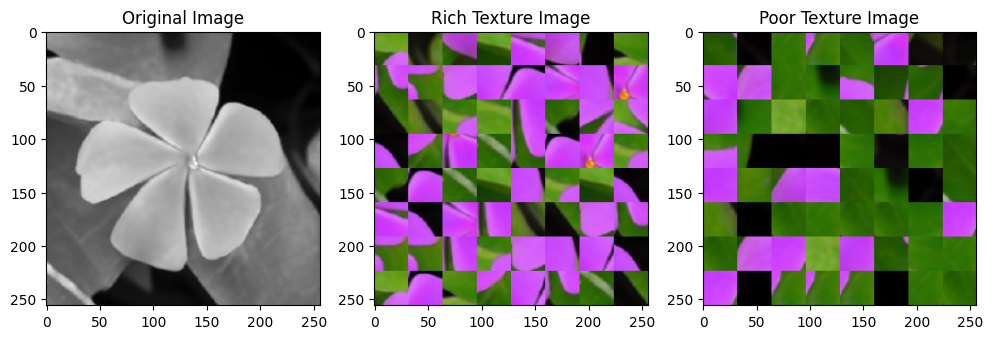

<ipython-input-40-df10d756f4c2>:21: RuntimeWarning: overflow encountered in scalar subtract
  div[i, j] += abs(patch[i, j, c] - patch[i + 1, j, c])
<ipython-input-40-df10d756f4c2>:20: RuntimeWarning: overflow encountered in scalar subtract
  div[i, j] += abs(patch[i, j, c] - patch[i, j + 1, c])
<ipython-input-40-df10d756f4c2>:26: RuntimeWarning: overflow encountered in scalar subtract
  div[M - 1, j] += abs(patch[M - 1, j, c] - patch[M - 1, j + 1, c])
<ipython-input-40-df10d756f4c2>:30: RuntimeWarning: overflow encountered in scalar subtract
  div[i, N - 1] += abs(patch[i, N - 1, c] - patch[i + 1, N - 1, c])


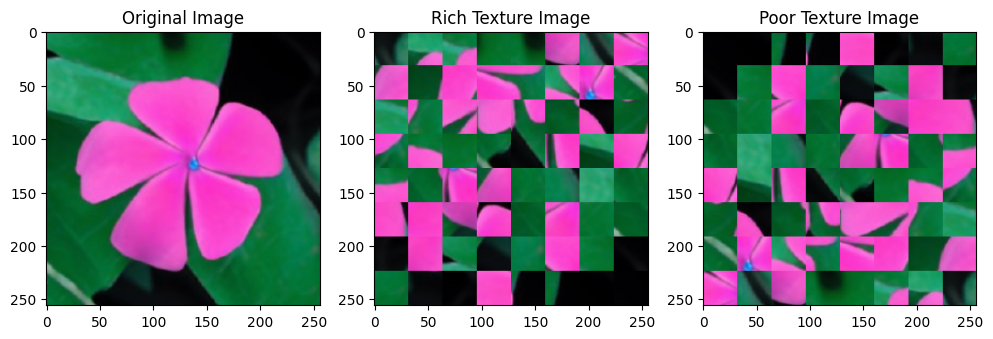

In [45]:
rich_texture_img, poor_texture_img = smash_n_reconstruct1(input_path="/img1.jpeg")

# Display the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(rich_texture_img, cmap='gray')
plt.title('Rich Texture Image')
plt.subplot(1, 3, 3)
plt.imshow(poor_texture_img, cmap='gray')
plt.title('Poor Texture Image')
plt.show()

img_path = '/img1.jpeg'
img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Change to cv2.IMREAD_COLOR

# Make sure to convert from BGR (OpenCV default) to RGB if you're going to display with matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rich_texture_img, poor_texture_img = smash_and_reconstruct(img)

# Display the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(rich_texture_img, cmap='gray')
plt.title('Rich Texture Image')
plt.subplot(1, 3, 3)
plt.imshow(poor_texture_img, cmap='gray')
plt.title('Poor Texture Image')
plt.show()